# Retail Rocket - Anonymous e-commerce site
## Buy or not buy

Retail rocket provided an anonymous [data set](https://www.kaggle.com/retailrocket/ecommerce-dataset/home) of an e-commerce site web activity to Kaggle for analysis. Three main data sets were provided; events, item properties, and item category tree.

1. **events** - The behaviorail event of each visitor to the site. Three different types of events were tracked, view, add to cart, and transaction (or buy).
2. **item properties** - Time series in weekly buckets of the item properties. The item properties can change over time, and thus the property of when the visitor interacted with the item is tracked.
3. **category tree** - A hierarchal data set relating category to parent category. This data is not utilized in this anlysis.

The data set is from an actual e-commerce site, and Retail Rocket anonymized many significant parts of the data. However, the category ID, but not the category name, and item availability was not anonymized. Some of the more interesting parts of the data, such as price and discount, were anonymized, which limited some more interesting types of analysis. My analysis focused on splitting the event data into individual sessions and attempting to classify whether or not a previous session will predict whether or not the next session will result in a buy or not.

First, let's import custom libraries to perform the analysis.

In [41]:
import data_transformation # loads and transform the raw csv data into data frames which can be used for analysis
import create_features # generates the features which will be utilized for classification
import model_selection # runs the clas`bsification models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

%config InlineBackend.figure_format = 'png'

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
%load_ext autoreload
%autoreload 2

### Data Loading

The events data set was a dump of site activty from May - September 2015. There was no indication of a session for each visitor, so the session for each visitor had to be calculated. A new session was calcualted and "started" each time there was a delay of at least 30 minutes (configurable) between events.

In [4]:
print(f'The session limit is set to {data_transformation.SESSION_TIME_LIMIT} minutes.')

The session limit is set to 30 minutes.


Let's load the events data.

In [5]:
events = data_transformation.load()

Total number of events: 2,756,101

Session calcualted and sequenced.

Added category and item availability property.


In [6]:
print(f'Number of unique items: {len(events.itemid.unique()):,}')
print(f'Number of unique visitors: {len(events.visitorid.unique()):,}')
print(f'Events start at {events.local_date_time.min():%m-%d-%Y} and ends at {events.local_date_time.max():%m-%d-%Y}')
events.sample(10)

Number of unique items: 235,061
Number of unique visitors: 1,407,580
Events start at 05-02-2015 and ends at 09-17-2015


,timestamp,visitorid,event,itemid,transactionid,local_date_time,minutes_since_prev_event,session_id,seq,categoryid,available
1338123,1436302686197,310759,view,447987,NaN,2015-07-07 13:58:06.197,0.095833,310759_78069,9.0,NaN,NaN
1649290,1437501181900,1254532,view,398883,NaN,2015-07-21 10:53:01.900,0.000000,1254532_1,1.0,NaN,NaN
1864309,1438230319036,440406,view,84773,NaN,2015-07-29 21:25:19.036,0.000000,440406_1,1.0,53,1.0
866476,1434317188460,1407335,view,71952,NaN,2015-06-14 14:26:28.460,0.545267,1407335_1,1.0,973,0.0
865802,1434314720384,828245,view,341333,NaN,2015-06-14 13:45:20.384,0.000000,828245_1,1.0,1263,1.0
1376252,1436428827368,703922,view,254888,NaN,2015-07-09 01:00:27.368,2.621250,703922_1,1.0,1429,1.0
1626636,1437418511459,833064,view,260404,NaN,2015-07-20 11:55:11.459,0.000000,833064_1,1.0,730,0.0
1245759,1435889700975,271126,view,295782,NaN,2015-07-02 19:15:00.975,0.000000,271126_1,1.0,29,0.0
1620021,1437401640061,736018,view,55925,NaN,2015-07-20 07:14:00.061,0.600583,736018_1,1.0,1018,1.0
1994946,1438827743462,879315,view,458803,NaN,2015-08-05 19:22:23.462,0.000000,879315_1,1.0,1503,1.0


The full data set is rather large. We are going to reduce the data set to analyze the first two sessions, starting in May 2015, for each visitor. The second session will be the observation data set, and the first session will be utilized to generate features to predict whether or not the second session will result in a buy or not.

In [7]:
obs, prior_obs = data_transformation.create_observations(events, 2)

In [8]:
buy_percent = prior_obs[prior_obs.buy_event == 1].shape[0] / prior_obs.shape[0]
print(f'Precentage of first session which results in a buy are {buy_percent:.2%}')
prior_obs.head()

Precentage of first session which results in a buy are 1.21%


,session_id,seq,buy_event,visitor_id
0,1000001_1,1.0,0,1000001
2,1000007_1,1.0,0,1000007
4,1000042_1,1.0,0,1000042
6,1000057_1,1.0,0,1000057
8,1000067_1,1.0,0,1000067


Historically, very fey sessions results in a buy transaction. The conversion rate for the first session is also not great at 1.21%, with the 2018 average around 2-3% based on this [article](https://www.smartinsights.com/ecommerce/ecommerce-analytics/ecommerce-conversion-rates/). There is potential for improvement for this company and a great question to answer is who will buy or not buy during their next session on the website. If the not buy can be accurately identifed, then effective ad campaigns can be developed to help convert the not buy into a buy. Any additional ad campaign strategies.

### Feature generation

The features we will generate will be calculated from the previous session and are the following,

1. Count of views
2. Length of session
3. Number of unique items viewed
4. Number of add to cart events
5. Number of transactions
6. Average item availability, e.g. if 3 pages were viewed and 2 out of the 3 items were available, then item availability is 66%. 

In [9]:
feature_df = create_features.gen_features(events, prior_obs, obs)

feature_df.sample(10)

,session_id,seq,buy_event,visitor_id,view_count,session_length,item_views,add_to_cart_count,transaction_count,avg_avail
2781,1019335_256360,2.0,0,1019335,1.0,0.000000,1.0,0.0,0.0,1.000000
38444,1270618_318686,2.0,0,1270618,2.0,16.794783,1.0,0.0,0.0,1.000000
157316,831599_209027,2.0,0,831599,1.0,0.000000,1.0,0.0,0.0,0.000000
7615,1052939_264483,2.0,0,1052939,1.0,0.000000,1.0,0.0,0.0,1.000000
101641,4428_1143,2.0,0,4428,2.0,0.517267,2.0,0.0,0.0,1.000000
18969,1132889_284840,2.0,0,1132889,3.0,11.951233,3.0,0.0,0.0,1.000000
29305,120674_30661,2.0,0,120674,1.0,0.000000,1.0,0.0,0.0,0.000000
74343,252093_63897,2.0,0,252093,2.0,14.356933,2.0,0.0,0.0,0.000000
8012,1055773_265101,2.0,0,1055773,3.0,2.389200,3.0,0.0,0.0,0.333333
107769,485447_121742,2.0,0,485447,1.0,0.000000,1.0,0.0,0.0,1.000000


All features are calculated and we can now generate the training and test data sets. The train/test split will be 75/25. The buy population is very small, and thus stratifed sampling will be used when generating the train and test data sets. Lastly, the train data set will be upsampled utilizing SMOTE for model selection. The original train data set prior to upsampling will also be returned and saved.

In [149]:
X, y, X_train, X_test, y_train, y_test, X_train_orig, y_train_orig = model_selection.create_Xy(feature_df)

In [11]:
X_train.describe()

,view_count,session_length,item_views,add_to_cart_count,transaction_count,avg_avail
count,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000
mean,2.654698,6.620509,2.010979,0.296388,0.071502,0.724582
std,4.626543,18.092930,3.325323,0.914663,0.467081,0.425255
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.333333
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.688323,5.573479,2.000000,0.000000,0.000000,1.000000
max,132.000000,391.790017,118.000000,44.000000,16.000000,1.000000


In [150]:
X_train_orig.describe()

,view_count,session_length,item_views,add_to_cart_count,transaction_count,avg_avail
count,106092.000000,106092.000000,106092.000000,106092.000000,106092.000000,106092.000000
mean,1.954869,3.271240,1.592665,0.073889,0.018182,0.574236
std,2.755685,9.470269,1.949301,0.518009,0.200336,0.478311
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.000000,1.514454,1.000000,0.000000,0.000000,1.000000
max,132.000000,391.790017,118.000000,44.000000,16.000000,1.000000


In [12]:
y_train.describeribe()

,0
count,208854.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [151]:
y_train_orig.describe()

count    106092.000000
mean          0.015694
std           0.124289
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: buy_event, dtype: float64

### Model selection

We will now train 2 different types of models, Gradient Boost, and Random Forrest. Previous experimenting found these two models generally provided better fits. The time to run these models is significant, and thus why these two models were chosen. However, the `cv_models` function can be extended to run other models. A 10-fold stratified cross validation will be performed and paramters will be tuned using `BayesianSearch` optimization. The metric utilized for model selection will be AUC. AUC was chosen to help distinguish which model can generally classify the training data set better.

In [ ]:
results = model_selection.cv_models(X_train, y_train, n_iters=10)

In [25]:
features = ['view_count', 'session_length', 'item_views', 'add_to_cart_count',
   'transaction_count', 'avg_avail']

for k, v in results.items():
    print(f'{k} Summary')
    print()
    print(f'Best out-of-sample AUC score: {v.best_score_}')
    print()
#     print(f'Feature Importance:')
#     for f, i in zip(features, v.best_estimator_.feature_importances_):
#         print(f'{f}: \t {i:.2%}')
#     print()
    print('----------------------------')
    pickle.dump( v.best_estimator_, open( f"../data/best_{k}_model.pkl", "wb" ) )

Gradient Boost Summary

Best out-of-sample AUC score: 0.8575232136022268

----------------------------
Random Forest Summary

Best out-of-sample AUC score: 0.7797512302557211

----------------------------


The Gradient Boost model appears to provide the better fit based on the best out of sample AUC score in the 10-fold cross validation and with the parameters tuned with Bayesian Search. Let's now review the two model's parameters and plot the ROC curve of the two models.

In [23]:
results['Gradient Boost'].best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)

In [24]:
results['Random Forest'].best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [18]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_gb_score = results['Gradient Boost'].best_estimator_.predict_proba(X_train)[:,1]
y_rf_score = results['Random Forest'].best_estimator_.predict_proba(X_train)[:,1]

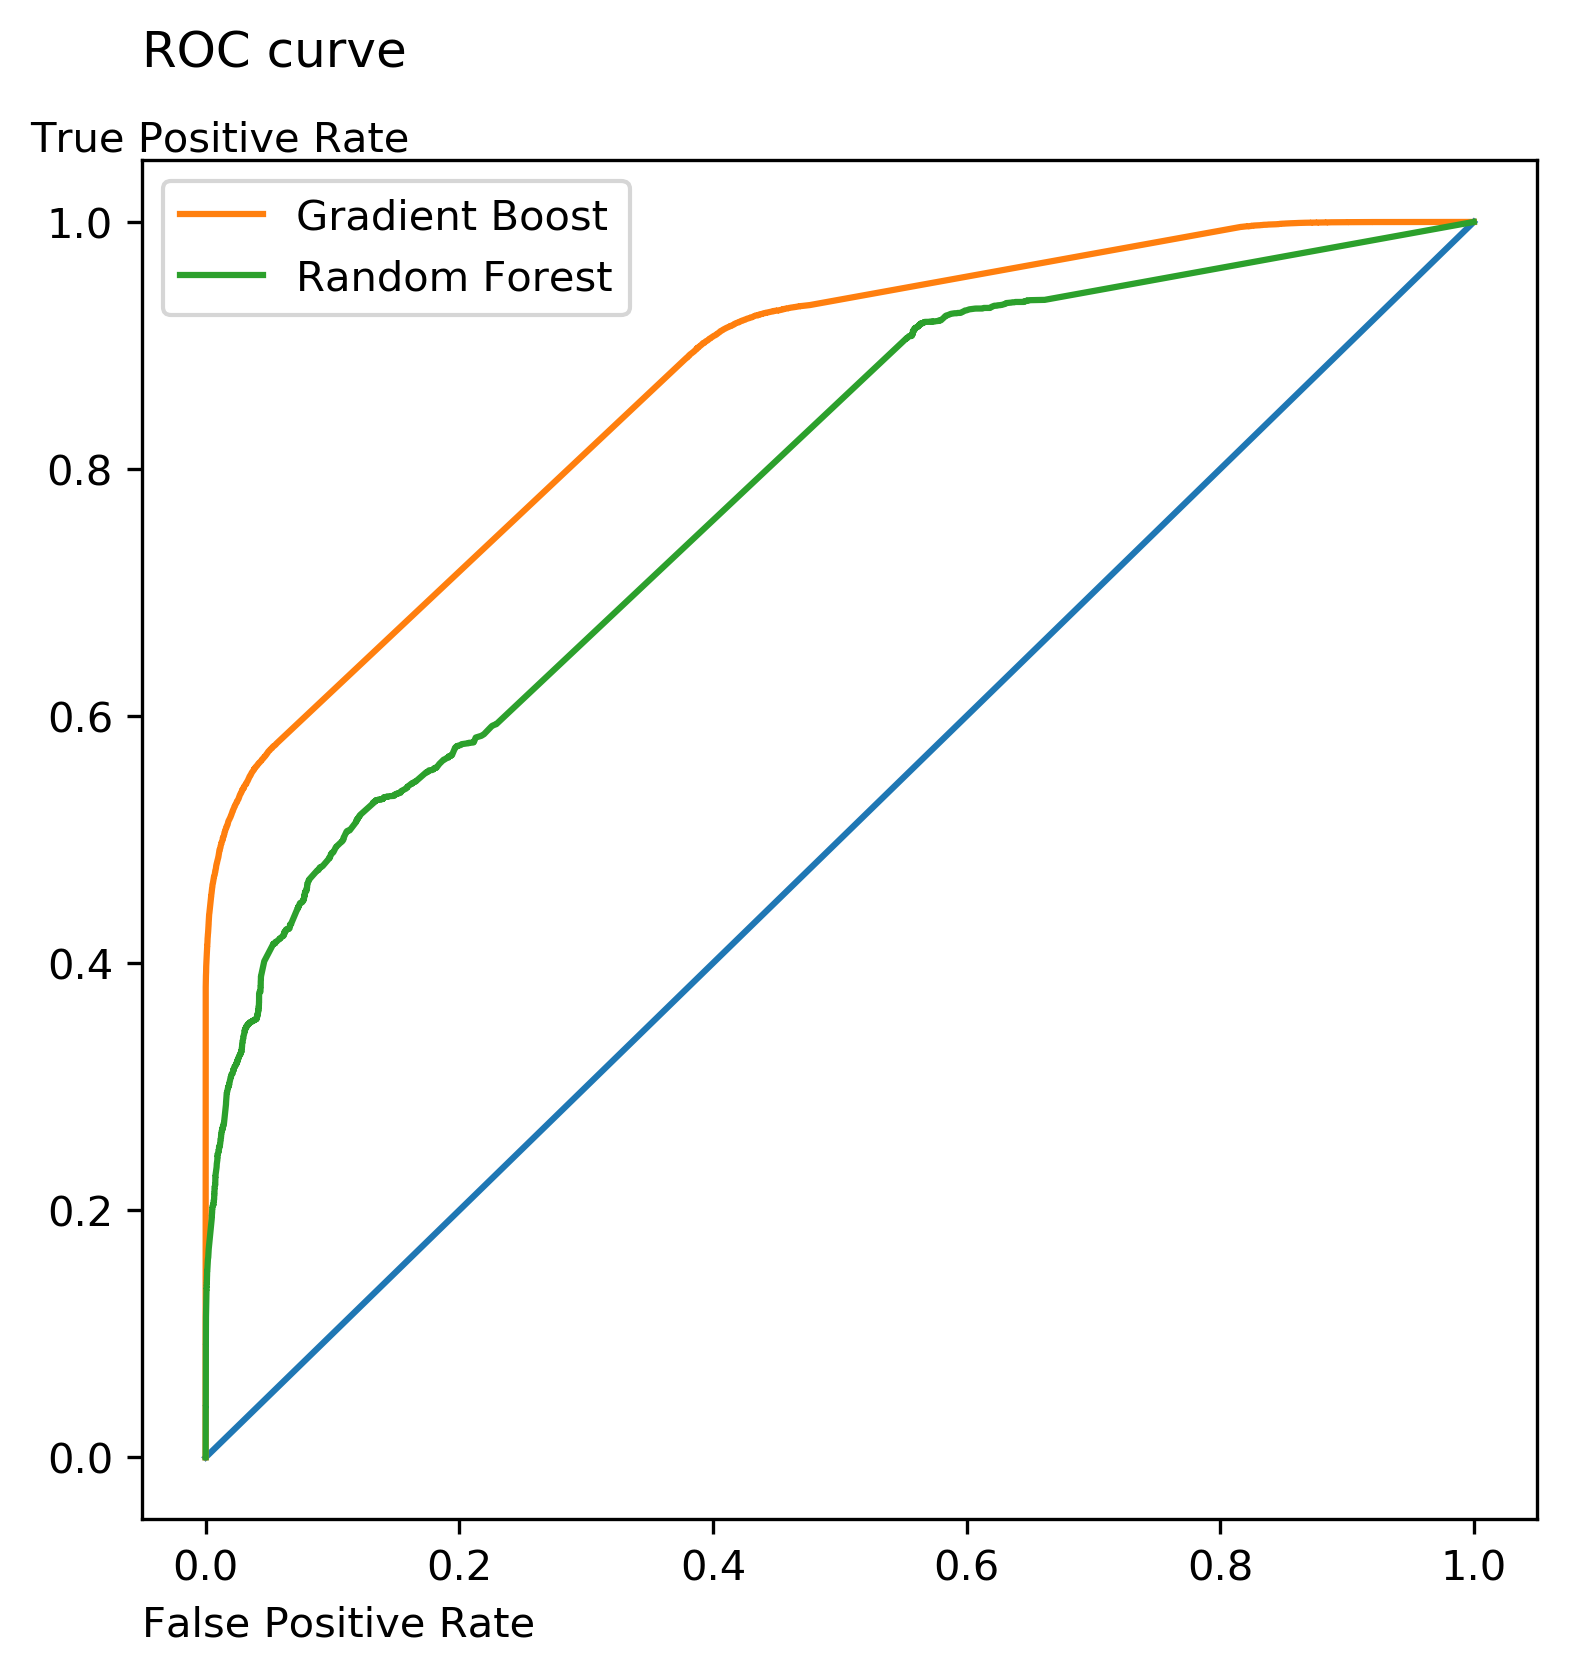

In [72]:
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_gb_score)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_rf_score)

# roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr_gb, tpr_gb, label='Gradient Boost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.legend()

title_style = {
    'position':(0,1.05),
    'horizontalalignment': 'left'
}

plt.xlabel('False Positive Rate', {
        'horizontalalignment':'left', 
        'fontweight':'ultralight', 
        'position':(0,0)})

plt.ylabel('True Positive Rate', {
    'horizontalalignment':'left', 
    'fontweight':'ultralight', 
    'position':(-0.5,1),
    'rotation':'horizontal'
    })
plt.title('ROC curve', title_style );

The Gradient Boost model performs better than the Random Forest model. Let's now look at the feature importance for the two models. 

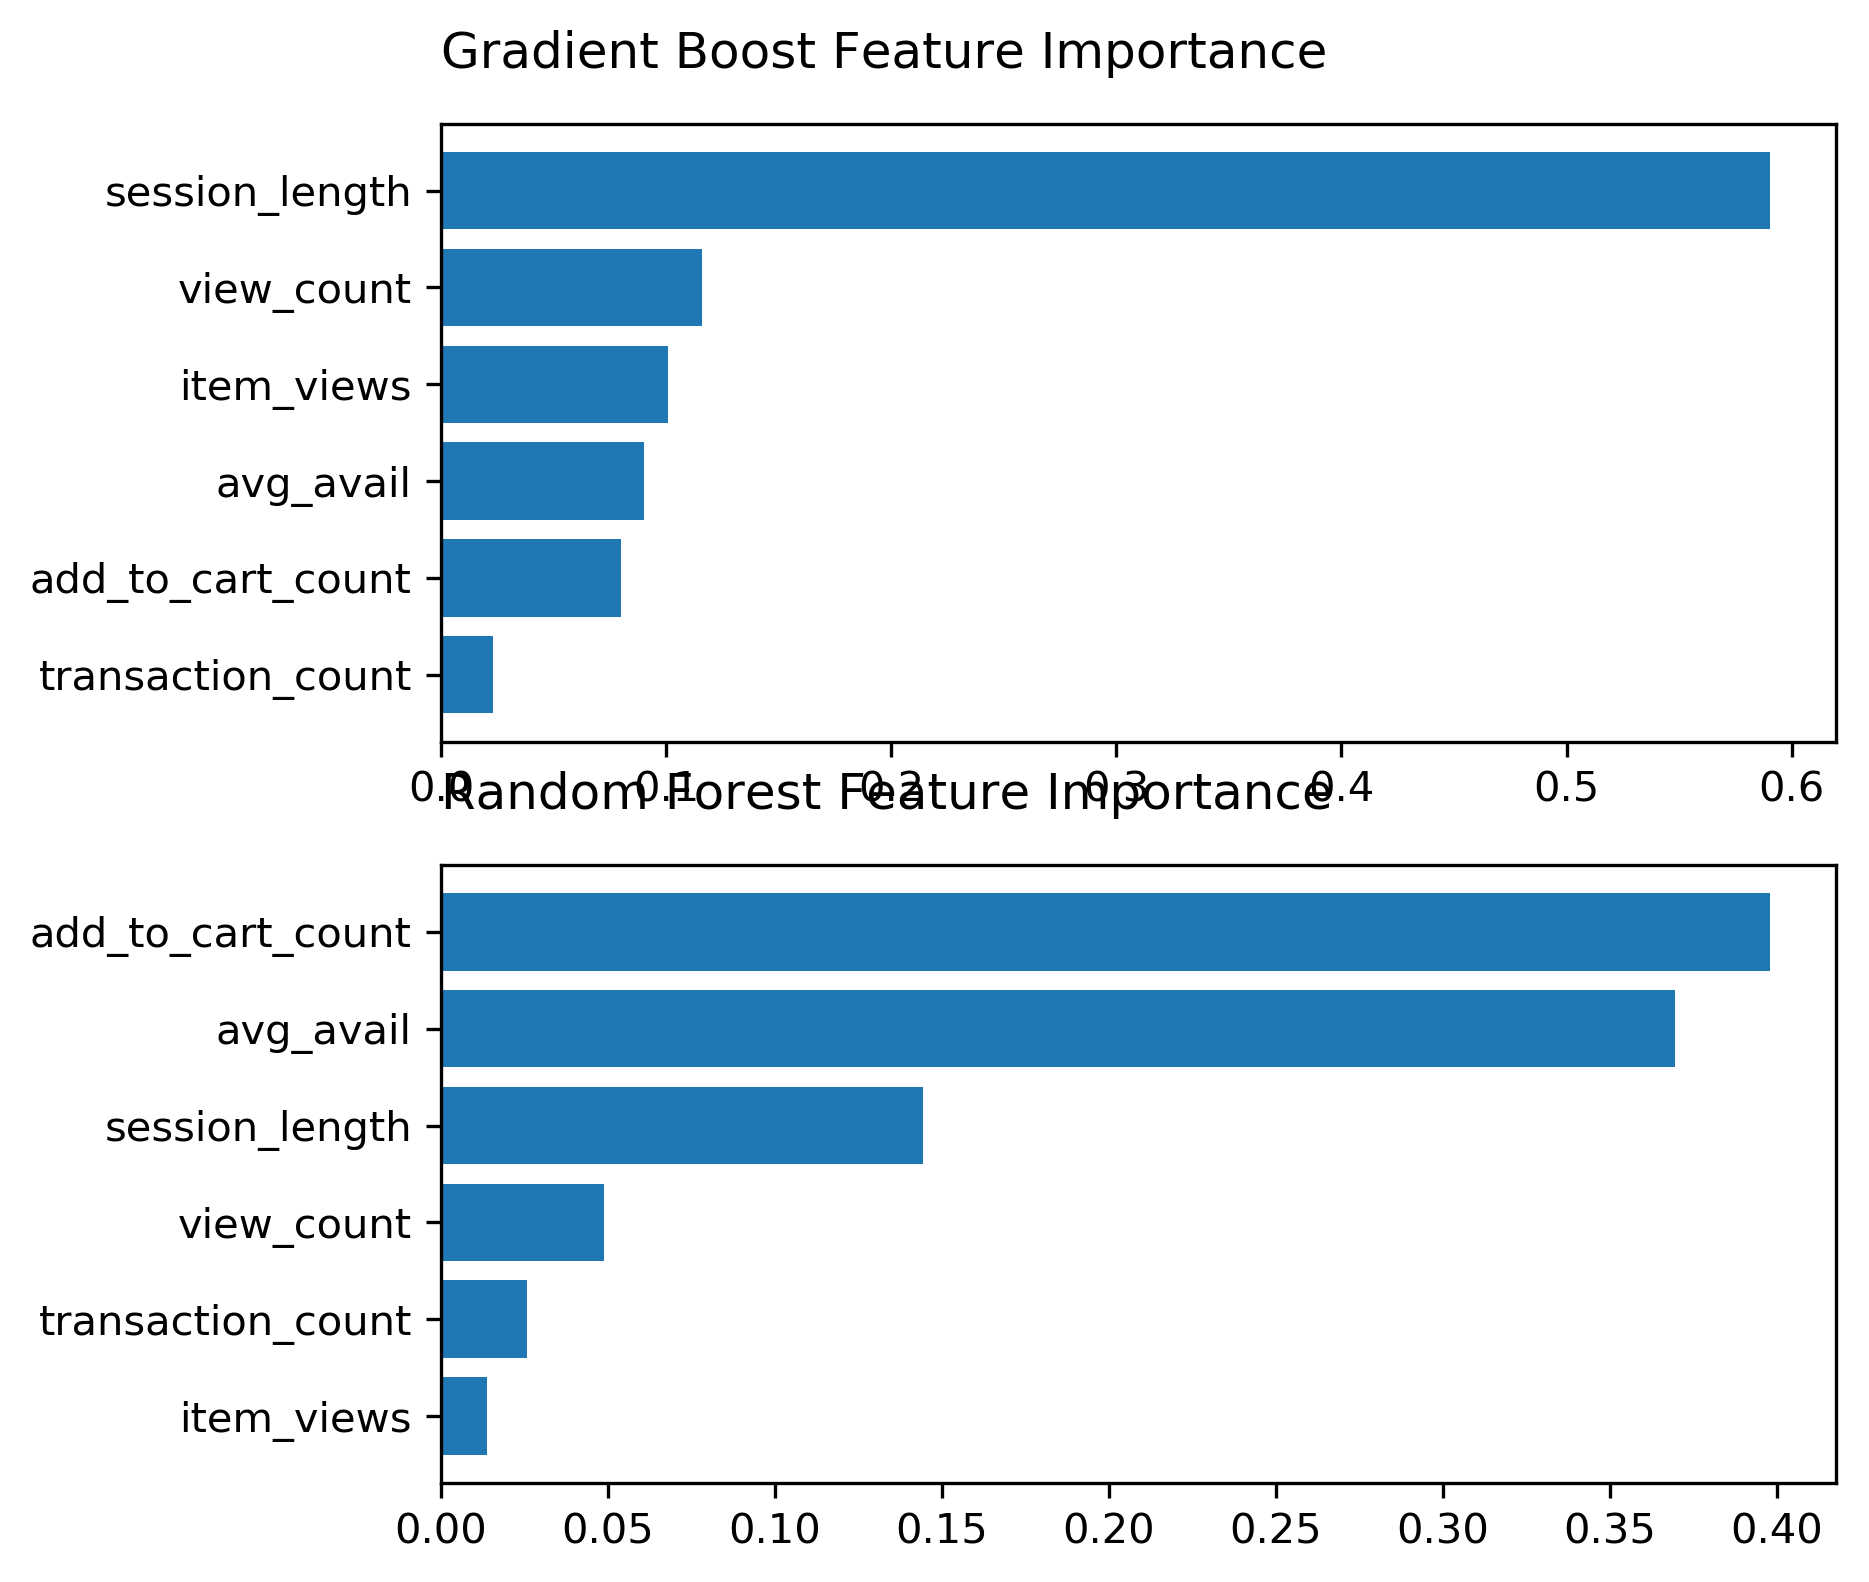

In [99]:
def plot_feature_performance(model, features, title_label):    
    feature_importance_df = pd.DataFrame(data={'features': features, 'importance': model.feature_importances_})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)
    plt.barh(feature_importance_df.features, feature_importance_df.importance)
    plt.title(title_label, title_style);

gb_model = results['Gradient Boost'].best_estimator_
rf_model = results['Random Forest'].best_estimator_

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plot_feature_performance(gb_model, features, 'Gradient Boost Feature Importance')
plt.subplot(2,1,2)
plot_feature_performance(rf_model, features, 'Random Forest Feature Importance')


Let's now see if there is a significant impact on reducing the number of features in the Gradient Boost model.

In [97]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

In [96]:
gb_model.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)

In [98]:
gb_feature_importance = gb_model.feature_importances_

thresholds = np.sort(gb_feature_importance)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(gb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)
    
    selection_model.fit(select_X_train, np.ravel(y_train))
    # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_train)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
    score = selection_model.score(select_X_train, y_train) ## DON'T THINK THIS IS AUC!!!
    print(f'Thresh={thresh:.3}, n={select_X_train.shape[1]}, AUC: {score:.3}')
# Don't forget to re-fit on the eventual feature space

Thresh=0.023, n=6, AUC: 0.761
Thresh=0.0799, n=5, AUC: 0.759
Thresh=0.0902, n=4, AUC: 0.752
Thresh=0.101, n=3, AUC: 0.73
Thresh=0.116, n=2, AUC: 0.706
Thresh=0.59, n=1, AUC: 0.663


The AUC change is minimal from using all 6 features down to 4. It could be advantageous to have a less complex model with a similar predictive power. The 2 features which will be dropped are the number of add to cart events and transaction events during the previous session. Let's now tune a 4 feature model to see if we can get a better AUC.

In [115]:
from skopt.space import Categorical, Real, Integer

selection = SelectFromModel(gb_model, threshold=0.0902, prefit=True)
select_X_train = selection.transform(X_train)

model = [('Gradient Boost', GradientBoostingClassifier)]

param_choices = [
    {
        'loss': Categorical(['deviance', 'exponential']),
        'learning_rate': Real(1e-2, 1),
        'n_estimators': Integer(100, 750),
        'subsample': Real(0.5, 1),
        'max_depth': Integer(3, 7),
        'random_state': [model_selection.RANDOM_STATE]
    }
]

In [116]:
gb_results = model_selection.cv_models(select_X_train, y_train, models = model, param_choices = param_choices)

Fitting Gradient Boost



In [120]:
gb_results['Gradient Boost'].best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2215793674768349, loss='exponential',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=540,
              presort='auto', random_state=1234,
              subsample=0.5838550173188863, verbose=0, warm_start=False)

In [121]:
pickle.dump( gb_results['Gradient Boost'].best_estimator_, open( f"../data/best_GB_less_features_model.pkl", "wb" ) )

In [122]:
gb_results['Gradient Boost'].best_score_

0.850152815412042

The AUC is basically the same 0.857 compared to 0.85 with only 4 features. The less complicated model is preferred with a slightly lower AUC.

### Cost benefit analysis

Now let's consider the cost of a false positive or false negative. A false positive would be identifying someone as not wanting to buy, but in reality will buy. This would be the scenario of providing a discount on an item when a discount is not needed, i.e. lost revenue but not lost sale. A false negative would be identifying someone as buy, but in reality will not buy. This would be the scenario of not providing a discount as we are confident the person will buy next, i.e. a lost sale to a competitor. 

The lost sale, false negative, is much more costly than providing a discount to a person who is already planning to make a purchase next time. We want the model to be sensitive false negatives, and not result in lost sales. 

Model should minimize the scenario,

* Model predicts a visitor will buy next, but in reality will NOT buy next. So, model says YES and actual is NO.
  * False positive
* Model predicts a visitor will not buy next, but in reality WILL buy next. So, model says NO and actual is YES.
  * False negative

In [124]:
from sklearn.model_selection import KFold, cross_val_predict

def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

Loop: 0


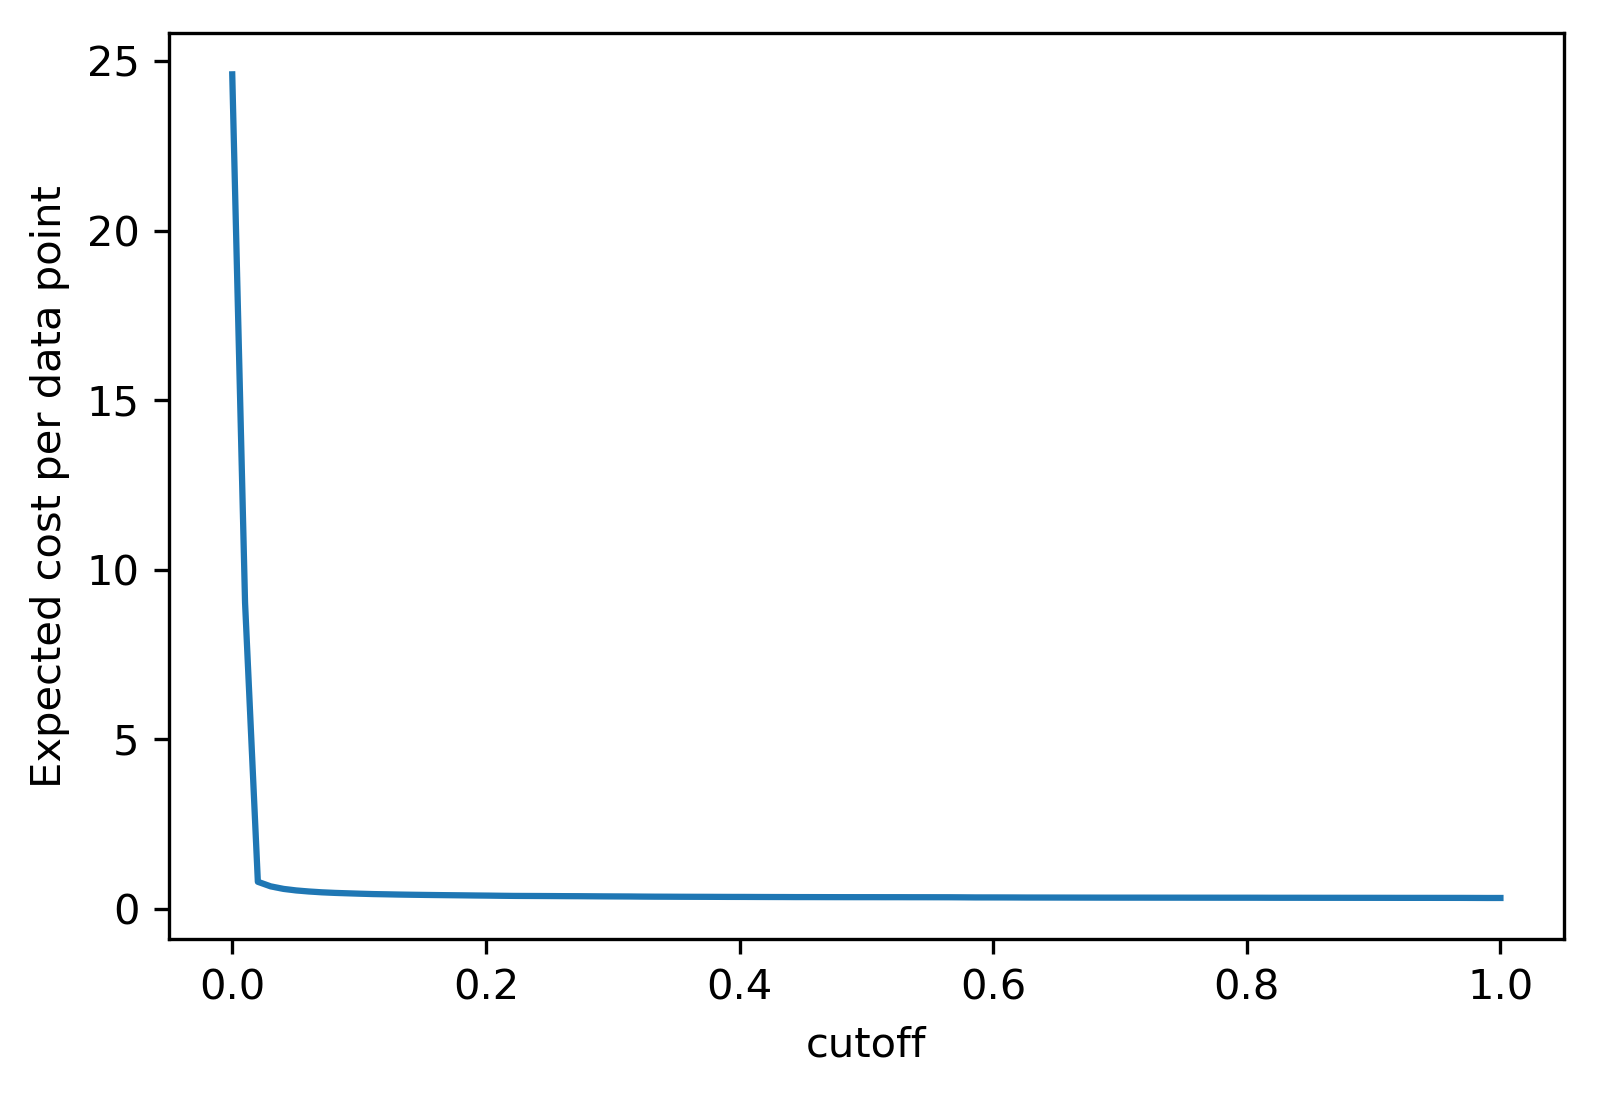

In [170]:
### 0 = not buy and 1 = buy, could i look at the accuracy to predict the not buy??

gb_less_features_model = gb_results['Gradient Boost'].best_estimator_

cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
obs = np.ravel(y_train_orig)

## Need to do this on the original X_train and y_train NOT the upsampled
select_X_train_orig = selection.transform(X_train_orig)

K = 1
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    
    prob = cross_val_predict(
                gb_less_features_model,
                select_X_train_orig,
                obs,
                cv=folds,
                method='predict_proba',
                n_jobs=5)[:,1]
    
    getcost = makecost(obs,prob,falsepos_cost=25,falseneg_cost=20)
    currentcost = getcost(cut)/select_X_train_orig.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
    print(f'Loop: {j}')
    
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [165]:
cost

array([49.2153037 , 17.73147834,  1.13827621,  0.86208197,  0.7183388 ,
        0.62590959,  0.56285111,  0.51894582,  0.47930098,  0.44996795,
        0.42542322,  0.4058553 ,  0.38819138,  0.37482562,  0.36255326,
        0.34952683,  0.33987483,  0.33092033,  0.32217321,  0.31425555,
        0.30611168,  0.29966444,  0.29316065,  0.28742978,  0.28381028,
        0.27806055,  0.27289522,  0.26812578,  0.26412925,  0.26086793,
        0.25713532,  0.25366663,  0.25102741,  0.24818082,  0.24461788,
        0.24103608,  0.23781246,  0.23653056,  0.23355201,  0.23236436,
        0.22961203,  0.22593598,  0.22329676,  0.22105343,  0.21901746,
        0.21686838,  0.21368246,  0.2117219 ,  0.21017607,  0.20906383,
        0.20759341,  0.2057271 ,  0.20378539,  0.20246578,  0.20071259,
        0.1984504 ,  0.19684802,  0.19509482,  0.19398258,  0.19315311,
        0.19187121,  0.19068356,  0.18957132,  0.18806319,  0.18678128,
        0.18631   ,  0.18499039,  0.18385929,  0.18274705,  0.18

In [166]:
cut

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [171]:
bestcut = cut[np.argmin(cost)]
bestcut

0.98989898989899

In [141]:
from sklearn.metrics import f1_score

In [142]:
f1_score(y_train, y_train_pred_cut)

0.7781580038926645

In [143]:
f1_score(y_train, gb_less_features_model.predict(select_X_train))

0.713935378893538

In [159]:
f1_score(y_train_orig, gb_less_features_model.predict(select_X_train_orig))

0.15544647031323047

In [145]:
select_X_test = selection.transform(X_test)
f1_score(y_test, gb_less_features_model.predict(select_X_test))

0.07045589105979871

In [163]:
from sklearn.metrics import confusion_matrix

In [172]:
y_train_pred = gb_less_features_model.predict_proba(select_X_train_orig)
# y_train_pred[:,1]

y_train_pred_cut = (y_train_pred[:,1] >= .98989898989899).astype(int)
# sum(y_train_pred_cut)

print(confusion_matrix(y_train_orig, y_train_pred_cut))

[[104427      0]
 [  1637     28]]


In [173]:
def baseline_pred(X_train):
    return (X_train.transaction_count >= 1).astype(int)

In [236]:
from sklearn.metrics import precision_score, recall_score

In [185]:
print(confusion_matrix(y_train_orig, gb_less_features_model.predict(select_X_train_orig)))
print(f'F1 score: {f1_score(y_train_orig, gb_less_features_model.predict(select_X_train_orig)):.2}')
print(f'precision score: {precision_score(y_train_orig, gb_less_features_model.predict(select_X_train_orig)):.2}')

[[98201  6226]
 [ 1000   665]]
F1 score: 0.16
precision score: 0.097


In [186]:
print(confusion_matrix(y_train_orig, gb_model.predict(X_train_orig)))
print(f'F1 score: {f1_score(y_train_orig, gb_model.predict(X_train_orig)):.2}')
print(f'precision score: {precision_score(y_train_orig, gb_model.predict(X_train_orig)):.2}')

[[98921  5506]
 [ 1117   548]]
F1 score: 0.14
precision score: 0.091


In [187]:
print(confusion_matrix(y_train, gb_model.predict(X_train)))
print(f'F1 score: {f1_score(y_train, gb_model.predict(X_train)):.2}')
print(f'precision score: {precision_score(y_train, gb_model.predict(X_train)):.2}')

[[98921  5506]
 [44393 60034]]
F1 score: 0.71
precision score: 0.92


In [208]:
print(confusion_matrix(y_train_ST, gb_st_model.predict(X_train_ST)))
print(f'F1 score: {f1_score(y_train_ST, gb_st_model.predict(X_train_ST)):.2}')
print(f'precision score: {precision_score(y_train_ST, gb_st_model.predict(X_train_ST)):.2}')

[[97384  2740]
 [41607 58517]]
F1 score: 0.73
precision score: 0.96


In [207]:
print(confusion_matrix(y_train_orig_ST, gb_st_model.predict(X_train_orig_ST)))
print(f'F1 score: {f1_score(y_train_orig_ST, gb_st_model.predict(X_train_orig_ST)):.2}')
print(f'precision score: {precision_score(y_train_orig_ST, gb_st_model.predict(X_train_orig_ST)):.2}')

[[99274  5153]
 [ 1041   624]]
F1 score: 0.17
precision score: 0.11


In [215]:
print(confusion_matrix(y_train_SE, gb_se_model.predict(X_train_SE)))
print(f'F1 score: {f1_score(y_train_SE, gb_se_model.predict(X_train_SE)):.2}')
print(f'precision score: {precision_score(y_train_SE, gb_se_model.predict(X_train_SE)):.2}')

[[90732     0]
 [    0 51553]]
F1 score: 1.0
precision score: 1.0


In [285]:
print('Train ------------------------')
y_pred = gb_se_model.predict(X_train_orig)
print(confusion_matrix(y_train_orig, y_pred))
print(f'F1 score: {f1_score(y_train_orig, y_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_pred):.2}')
print()
y_base_pred = baseline_pred(X_train_orig)
print(confusion_matrix(y_train_orig, y_base_pred))
print(f'F1 score: {f1_score(y_train_orig, y_base_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_base_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_base_pred):.2}')

Train ------------------------
[[98612  5815]
 [  769   896]]
F1 score: 0.21
precision score: 0.13
recall score: 0.54

[[103144   1283]
 [  1543    122]]
F1 score: 0.079
precision score: 0.087
recall score: 0.073


Model identifies more than double of the sessions correctly as will buy in the next session. This means we will be offering less discounts to those who have already shown they will buy based on their first session. However, in my model the precision has gone down, which means we will not offer a discount to those who eventually will not buy, so a lost sale.

1. Need to plot the ROC curve of each of the best models.
2. Need to say which model is best
3. Need to think about cost benefit analysis on where to set the probability
4. Report some metric on test data set

In [188]:
X_ST, y_ST, X_train_ST, X_test_ST, y_train_ST, y_test_ST, X_train_orig_ST, y_train_orig_ST = model_selection.create_Xy_SMOTETomek(feature_df)

In [189]:
model

[('Gradient Boost',
  sklearn.ensemble.gradient_boosting.GradientBoostingClassifier)]

In [190]:
param_choices

[{'loss': Categorical(categories=('deviance', 'exponential'), prior=None),
  'learning_rate': Real(low=0.01, high=1, prior='uniform', transform='identity'),
  'n_estimators': Integer(low=100, high=750),
  'subsample': Real(low=0.5, high=1, prior='uniform', transform='identity'),
  'max_depth': Integer(low=3, high=7),
  'random_state': [1234]}]

In [192]:
new_sample_results = model_selection.cv_models(X_train_ST, y_train_ST, models = model, param_choices = param_choices)

Fitting Gradient Boost



In [193]:
new_sample_results['Gradient Boost'].best_score_

0.8759283097726922

In [196]:
gb_st_model = new_sample_results['Gradient Boost'].best_estimator_
pickle.dump(gb_st_model, open('../data/best_gb_smote_tomenk_model.pkl', 'wb'))

In [209]:
X_SE, y_SE, X_train_SE, X_test_SE, y_train_SE, y_test_SE, X_train_orig_SE, y_train_orig_SE = model_selection.create_Xy_SMOTEENN(feature_df)

In [210]:
smote_enn_results = model_selection.cv_models(
    X_train_SE, 
    y_train_SE, 
    models = model, 
    param_choices = param_choices)

Fitting Gradient Boost



In [211]:
gb_se_model = smote_enn_results['Gradient Boost'].best_estimator_
pickle.dump(gb_se_model, open('../data/best_gb_smote_ENN_model.pkl', 'wb'))

In [213]:
smote_enn_results['Gradient Boost'].best_score_

0.9993544075914389

In [214]:
gb_se_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5051940292083749, loss='exponential',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=684,
              presort='auto', random_state=1234,
              subsample=0.6031539052982576, verbose=0, warm_start=False)

Loop: 0


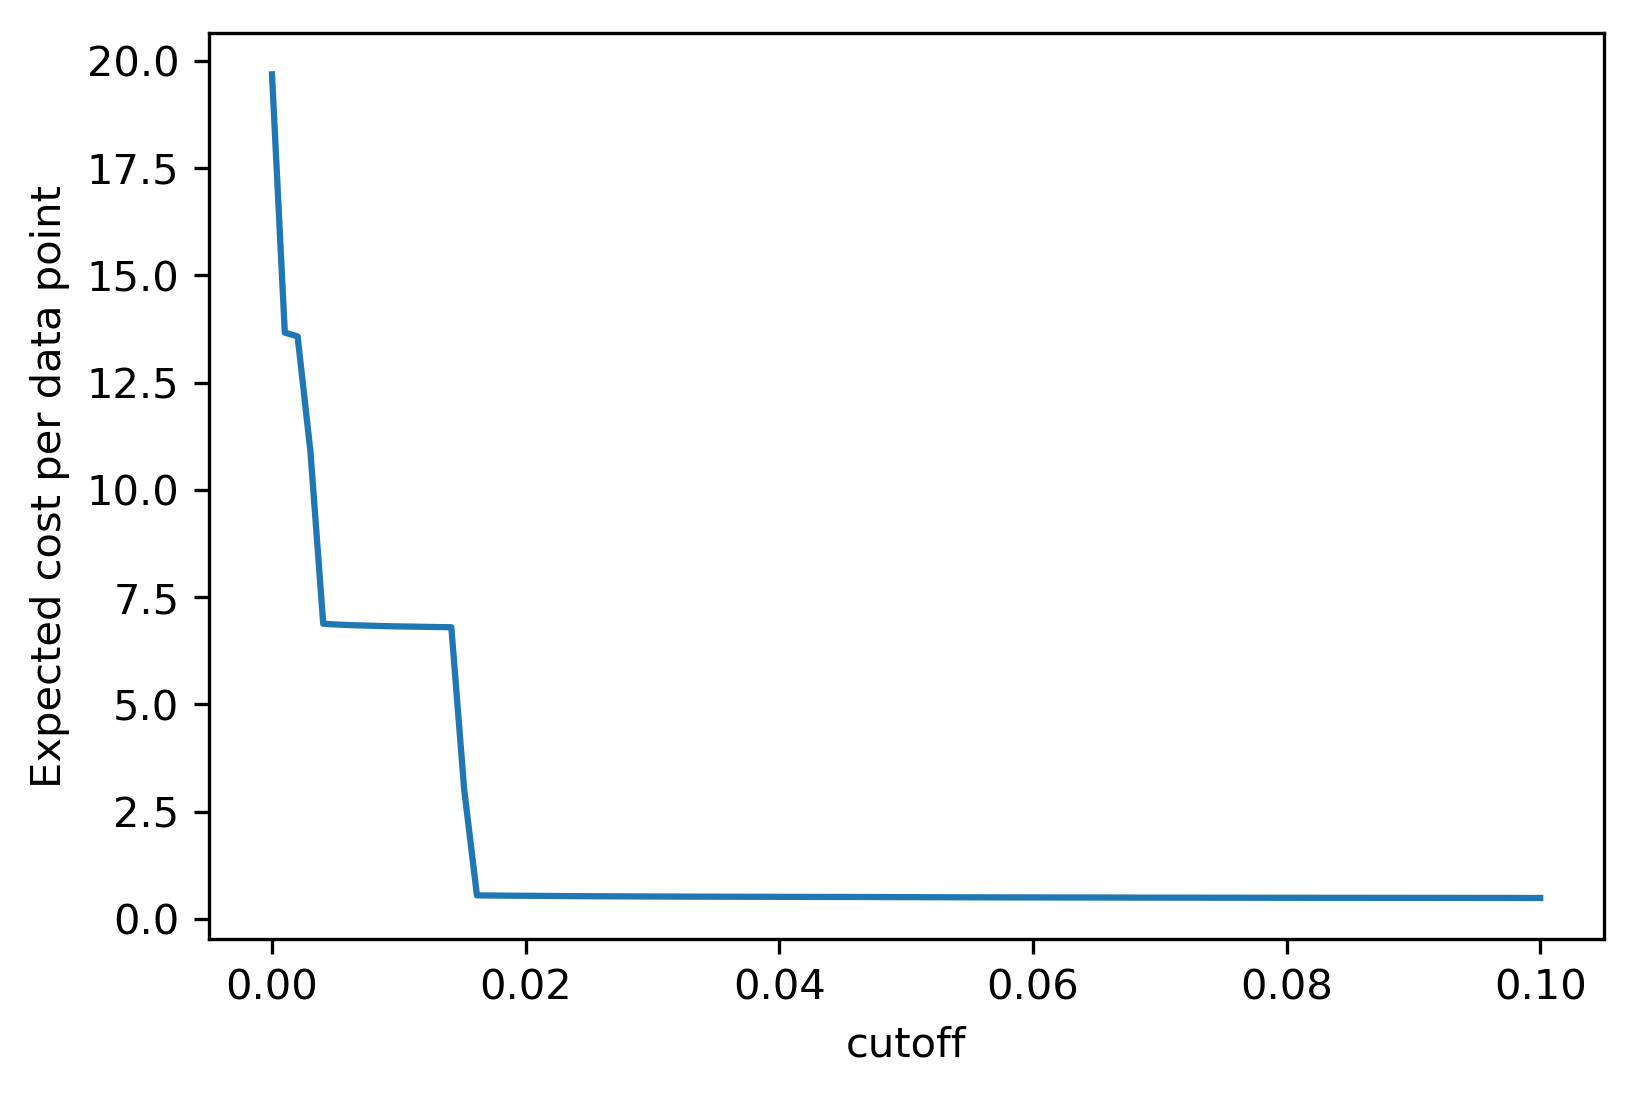

In [234]:
### 0 = not buy and 1 = buy, could i look at the accuracy to predict the not buy??

cut = np.linspace(0,.1,100)
cost = np.zeros_like(cut)
obs = np.ravel(y_train_orig)

## Need to do this on the original X_train and y_train NOT the upsampled

K = 1
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    
    prob = cross_val_predict(
                gb_se_model,
                X_train_orig,
                obs,
                cv=folds,
                method='predict_proba',
                n_jobs=5)[:,1]
    
    getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
    currentcost = getcost(cut)/X_train_orig.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
    print(f'Loop: {j}')
    
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [235]:
cost

array([19.68612148, 13.66559213, 13.57854504, 10.89954945,  6.87978358,
        6.86361837,  6.84995099,  6.84066659,  6.83265468,  6.82407722,
        6.81809184,  6.81380311,  6.80805339,  6.80395317,  6.7997587 ,
        3.02713682,  0.55022999,  0.54674245,  0.54415036,  0.54155827,
        0.53995589,  0.53792934,  0.53609132,  0.53364061,  0.53137843,
        0.5295404 ,  0.52845643,  0.52756098,  0.52567583,  0.52435622,
        0.52364929,  0.52251819,  0.52110432,  0.52035026,  0.52002036,
        0.51907778,  0.5181352 ,  0.51742827,  0.51667421,  0.51629718,
        0.51497757,  0.51483618,  0.51427063,  0.51361083,  0.51304528,
        0.51285677,  0.5121027 ,  0.51134864,  0.51002903,  0.50889794,
        0.50833239,  0.50738981,  0.50663575,  0.50569317,  0.50517475,
        0.50385514,  0.5032896 ,  0.50272405,  0.50234702,  0.5021585 ,
        0.50140444,  0.50102741,  0.50050899,  0.50079177,  0.50022622,
        0.49947216,  0.49890661,  0.49777552,  0.49720997,  0.49

In [244]:
y_train_proba = gb_se_model.predict_proba(X_train_orig)

In [257]:
probs = np.linspace(0.98, 1, 100)
# print(probs)
for p in probs:
    y_p = (y_train_proba[:,1] >= p).astype(int)
    print(p, precision_score(y_train_orig, y_p))
    

0.98 0.15464844452436613
0.9802020202020202 0.1548433561397191
0.9804040404040404 0.1548433561397191
0.9806060606060606 0.15462245449630563
0.9808080808080808 0.15467820443482963
0.981010101010101 0.15473399458972048
0.9812121212121212 0.1547898250045102
0.9814141414141414 0.1548736462093863
0.9816161616161616 0.154985549132948
0.9818181818181818 0.1550850524791893
0.982020202020202 0.1550850524791893
0.9822222222222222 0.1550850524791893
0.9824242424242424 0.1552536231884058
0.9826262626262626 0.1551286698079014
0.9828282828282828 0.1552412042074719
0.983030303030303 0.15529753265602322
0.9832323232323232 0.15532571221193975
0.9834343434343434 0.15538210201488473
0.9836363636363636 0.15543853277646633
0.9838383838383838 0.15555151735417044
0.984040404040404 0.1556646663029642
0.9842424242424243 0.15565264882577826
0.9844444444444445 0.15565264882577826
0.9846464646464647 0.1557377049180328
0.9848484848484849 0.15587967183226983
0.9850505050505051 0.15590809628008753
0.9852525252525253

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [258]:
y_p = (y_train_proba[:,1] >= 0.9915).astype(int)
confusion_matrix(y_train_orig, y_p)

array([[99960,  4467],
       [  833,   832]])

In [265]:
X_none, y_none, _, X_test_none, _, y_test_none, X_train_none, y_train_none = model_selection.create_Xy(feature_df)

In [266]:
y_train_none.describe()

count    106092.000000
mean          0.015694
std           0.124289
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: buy_event, dtype: float64

In [267]:
smote_enn_results = model_selection.cv_models(
    X_train_none, 
    y_train_none, 
    models = model, 
    param_choices = param_choices)

Fitting Gradient Boost



In [269]:
smote_enn_results['Gradient Boost'].best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2130040083610986, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=244,
              presort='auto', random_state=1234,
              subsample=0.6303945371800836, verbose=0, warm_start=False)

In [273]:
no_sample_model = smote_enn_results['Gradient Boost'].best_estimator_
pickle.dump(no_sample_model, open('../data/best_no_sample_model_auc.pkl','wb'))

In [271]:
confusion_matrix(y_train_none, no_sample_model.predict(X_train_none))

array([[104426,      1],
       [  1634,     31]])

In [272]:
print('Train ------------------------')
y_pred = no_sample_model.predict(X_train_none)
print(confusion_matrix(y_train_orig, y_pred))
print(f'F1 score: {f1_score(y_train_orig, y_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_pred):.2}')
print()
y_base_pred = baseline_pred(X_train_orig)
print(confusion_matrix(y_train_orig, y_base_pred))
print(f'F1 score: {f1_score(y_train_orig, y_base_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_base_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_base_pred):.2}')

Train ------------------------
[[104426      1]
 [  1634     31]]
F1 score: 0.037
precision score: 0.97
recall score: 0.019

[[103144   1283]
 [  1543    122]]
F1 score: 0.079
precision score: 0.087
recall score: 0.073


In [280]:
smote_enn_results = model_selection.cv_models(
    X_train_none, 
    y_train_none, 
    models = model, 
    param_choices = param_choices,
    scoring = 'f1')

Fitting Gradient Boost



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

In [281]:
no_sample_model_f1_10 = smote_enn_results['Gradient Boost'].best_estimator_
pickle.dump(no_sample_model_f1, open('../data/best_no_sample_model_f1_10.pkl','wb'))

In [282]:
confusion_matrix(y_train_none, no_sample_model_f1_10.predict(X_train_none))

array([[101489,   2938],
       [  1074,    591]])

In [283]:
print('Train ------------------------')
y_pred = no_sample_model_f1_10.predict(X_train_none)
print(confusion_matrix(y_train_orig, y_pred))
print(f'F1 score: {f1_score(y_train_orig, y_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_pred):.2}')
print()
y_base_pred = baseline_pred(X_train_orig)
print(confusion_matrix(y_train_orig, y_base_pred))
print(f'F1 score: {f1_score(y_train_orig, y_base_pred):.2}')
print(f'precision score: {precision_score(y_train_orig, y_base_pred):.2}')
print(f'recall score: {recall_score(y_train_orig, y_base_pred):.2}')

Train ------------------------
[[101489   2938]
 [  1074    591]]
F1 score: 0.23
precision score: 0.17
recall score: 0.35

[[103144   1283]
 [  1543    122]]
F1 score: 0.079
precision score: 0.087
recall score: 0.073


In [284]:
print('Test ------------------------')
y_pred_test = no_sample_model_f1_10.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(f'F1 score: {f1_score(y_test, y_pred_test):.2}')
print(f'precision score: {precision_score(y_test, y_pred_test):.2}')
print(f'recall score: {recall_score(y_test, y_pred_test):.2}')
print()
y_base_pred_test = baseline_pred(X_test)
print(confusion_matrix(y_test, y_base_pred_test))
print(f'F1 score: {f1_score(y_test, y_base_pred_test):.2}')
print(f'precision score: {precision_score(y_test, y_base_pred_test):.2}')
print(f'recall score: {recall_score(y_test, y_base_pred_test):.2}')

Test ------------------------
[[33687  1122]
 [  501    54]]
F1 score: 0.062
precision score: 0.046
recall score: 0.097

[[34388   421]
 [  513    42]]
F1 score: 0.083
precision score: 0.091
recall score: 0.076


In [286]:
import dill

dill.dump_session('../data/session_dumps/session_20181030.pkl')

In [299]:
events_by_day = events.set_index('local_date_time').groupby(pd.TimeGrouper('D'))['event'].count().dropna().reset_index()
events_by_day.tail()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


,local_date_time,event
134,2015-09-13,17688
135,2015-09-14,21291
136,2015-09-15,17023
137,2015-09-16,11086
138,2015-09-17,8414


In [370]:
def plot_ts (df, f_name, t_name):
    font = {'weight' : 'light',
            'size'   : 8,
            'color' : 'grey'
           }

    # title_font = {'fontsize': 10,
    #  'fontweight' : 'light',
    #  'verticalalignment': 'baseline',
    #  'horizontalalignment': 'left'}

    fig, ax = plt.subplots()
    plt.plot(df.iloc[:,0], df.iloc[:,1], color = '#a22c29')
    my_ticks = df.local_date_time.values
    plt.xticks([my_ticks[0], my_ticks[-1]], ['05/02', '09/17'], **font)
    plt.yticks(**font)
    # plt.ylabel('Total Events', **font)
    plt.title(t_name, loc='left', pad=20, **font)

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left= False,
        bottom = False) # labels along the bottom edge are off

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_ylim(ymin=0)
    plt.savefig(f'../docs/{f_name}.png');

In [355]:
visitors_by_day = events.set_index('local_date_time').groupby(pd.TimeGrouper('D'))['visitorid'].nunique().dropna().reset_index()
visitors_by_day.tail()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


,local_date_time,visitorid
134,2015-09-13,11355
135,2015-09-14,13519
136,2015-09-15,10431
137,2015-09-16,6665
138,2015-09-17,5147


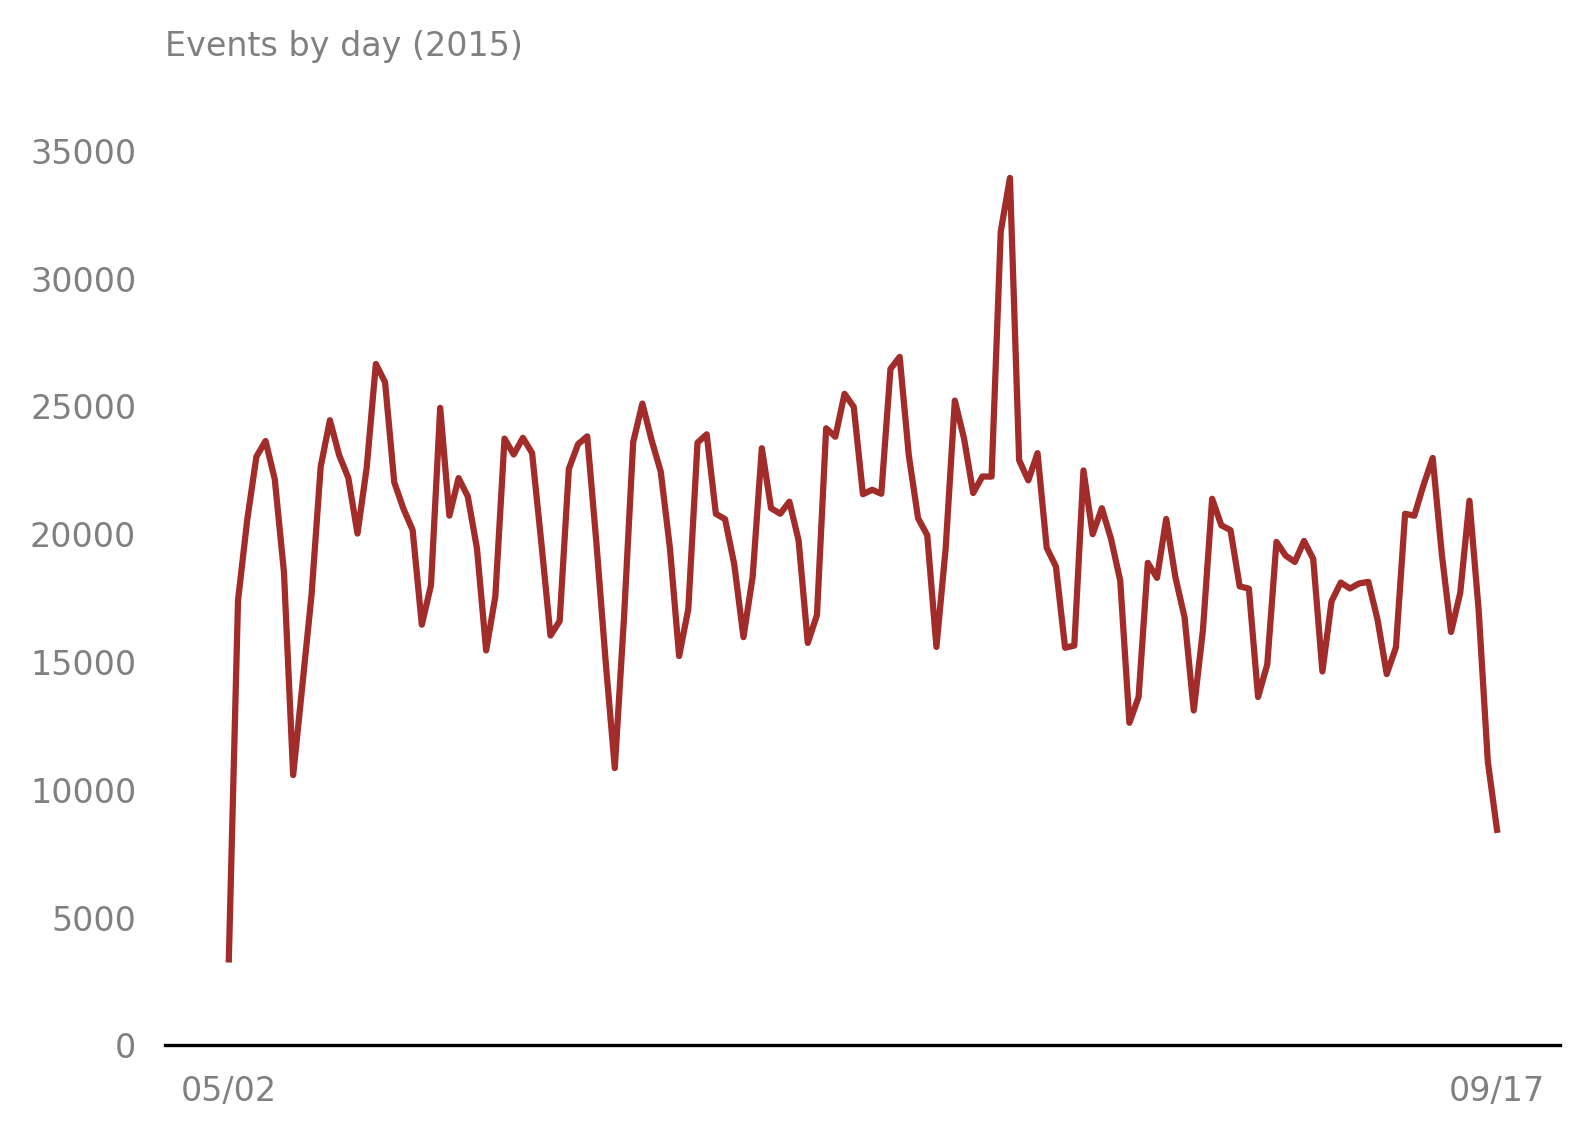

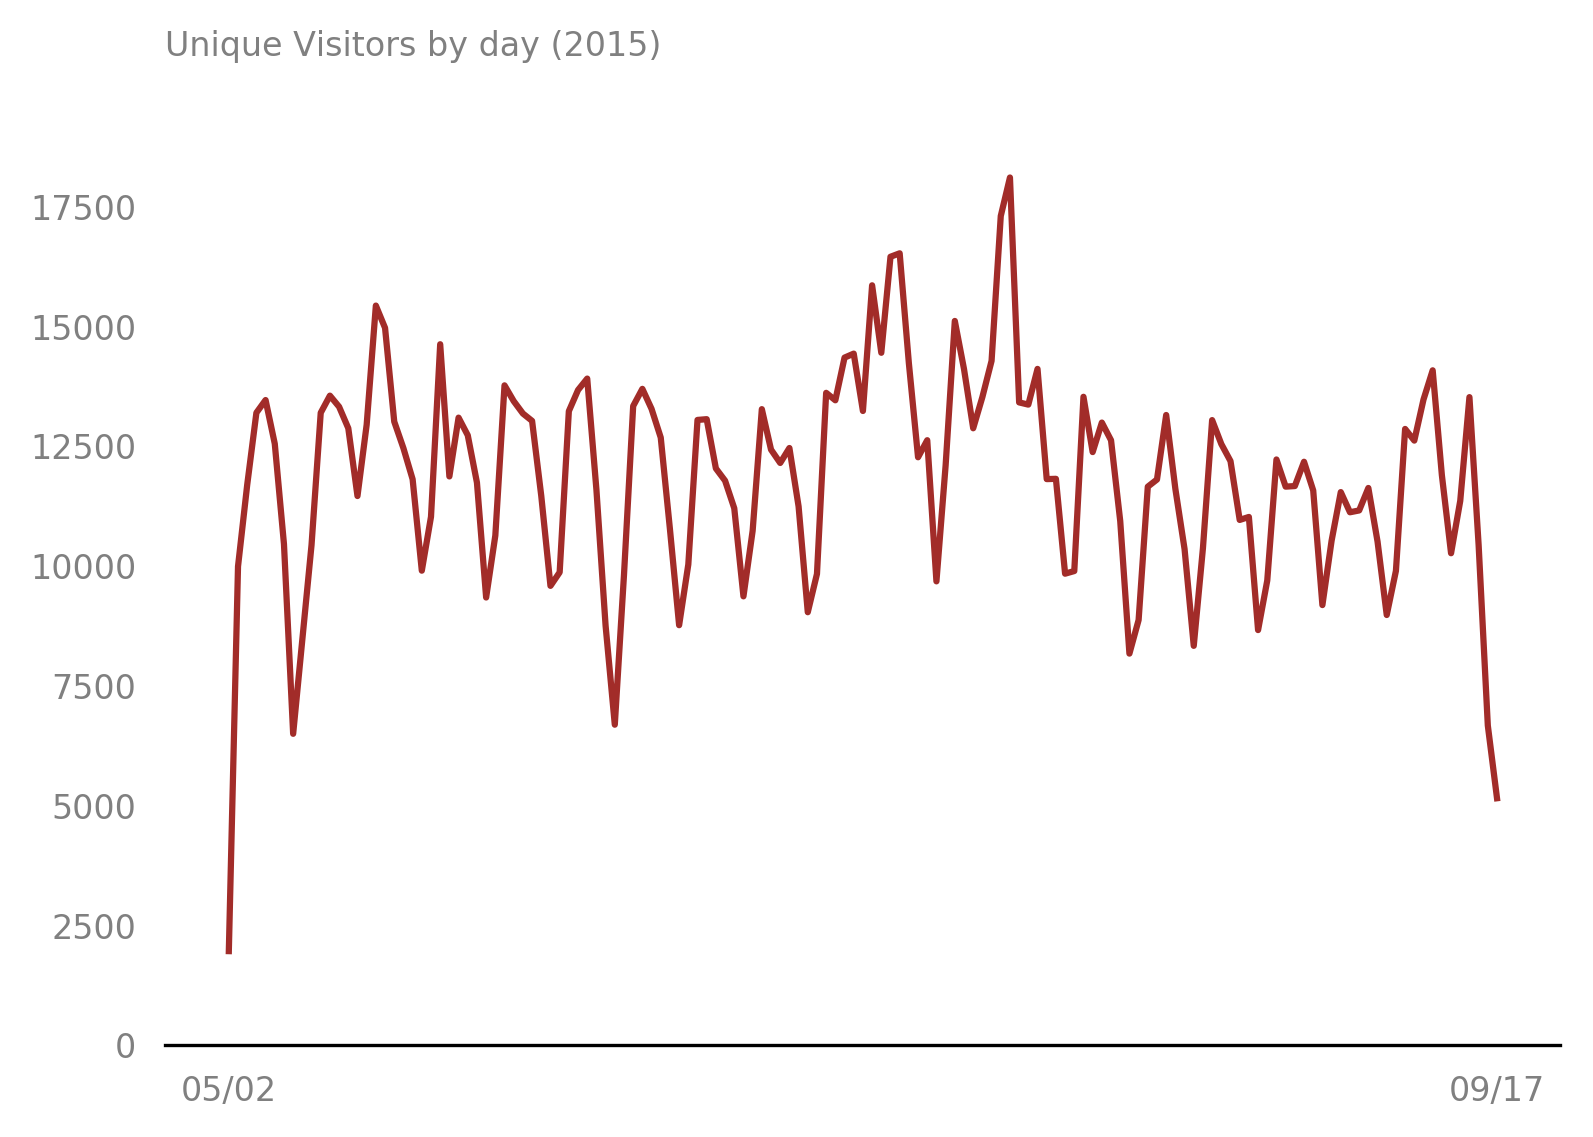

In [371]:
plot_ts(events_by_day, 'events_ts', 'Events by day (2015)')
plot_ts(visitors_by_day, 'visitors_ts', 'Unique Visitors by day (2015)')

In [375]:
len(events[events.seq==2].session_id.unique())

181633

In [376]:
print('Test ------------------------')
y_pred_test = gb_se_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(f'F1 score: {f1_score(y_test, y_pred_test):.2}')
print(f'precision score: {precision_score(y_test, y_pred_test):.2}')
print(f'recall score: {recall_score(y_test, y_pred_test):.2}')
print()
y_base_pred_test = baseline_pred(X_test)
print(confusion_matrix(y_test, y_base_pred_test))
print(f'F1 score: {f1_score(y_test, y_base_pred_test):.2}')
print(f'precision score: {precision_score(y_test, y_base_pred_test):.2}')
print(f'recall score: {recall_score(y_test, y_base_pred_test):.2}')

Test ------------------------
[[32612  2197]
 [  440   115]]
F1 score: 0.08
precision score: 0.05
recall score: 0.21

[[34388   421]
 [  513    42]]
F1 score: 0.083
precision score: 0.091
recall score: 0.076


In [426]:
def plot_errors(data, t_name, f_name, color):
    font = {'weight' : 'light',
            'size'   : 8,
            'color'  : 'grey'
       }

    fig, ax = plt.subplots()
    plt.barh(list(data.keys()), list(data.values()), color=color)
    
#     plt.plot(df.iloc[:,0], df.iloc[:,1], color = '#a22c29')
#     my_ticks = df.local_date_time.values
#     plt.xticks([my_ticks[0], my_ticks[-1]], ['05/02', '09/17'], **font)
#     plt.yticks(**font)
#     # plt.ylabel('Total Events', **font)
    plt.title(t_name, loc='left', pad=20, **font)
    plt.xlabel('Sessions', horizontalalignment='left', x=0.0, **font)

#     plt.tick_params(
#         axis='both',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         left= False,
#         bottom = False) # labels along the bottom edge are off

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(f'../docs/{f_name}.png')


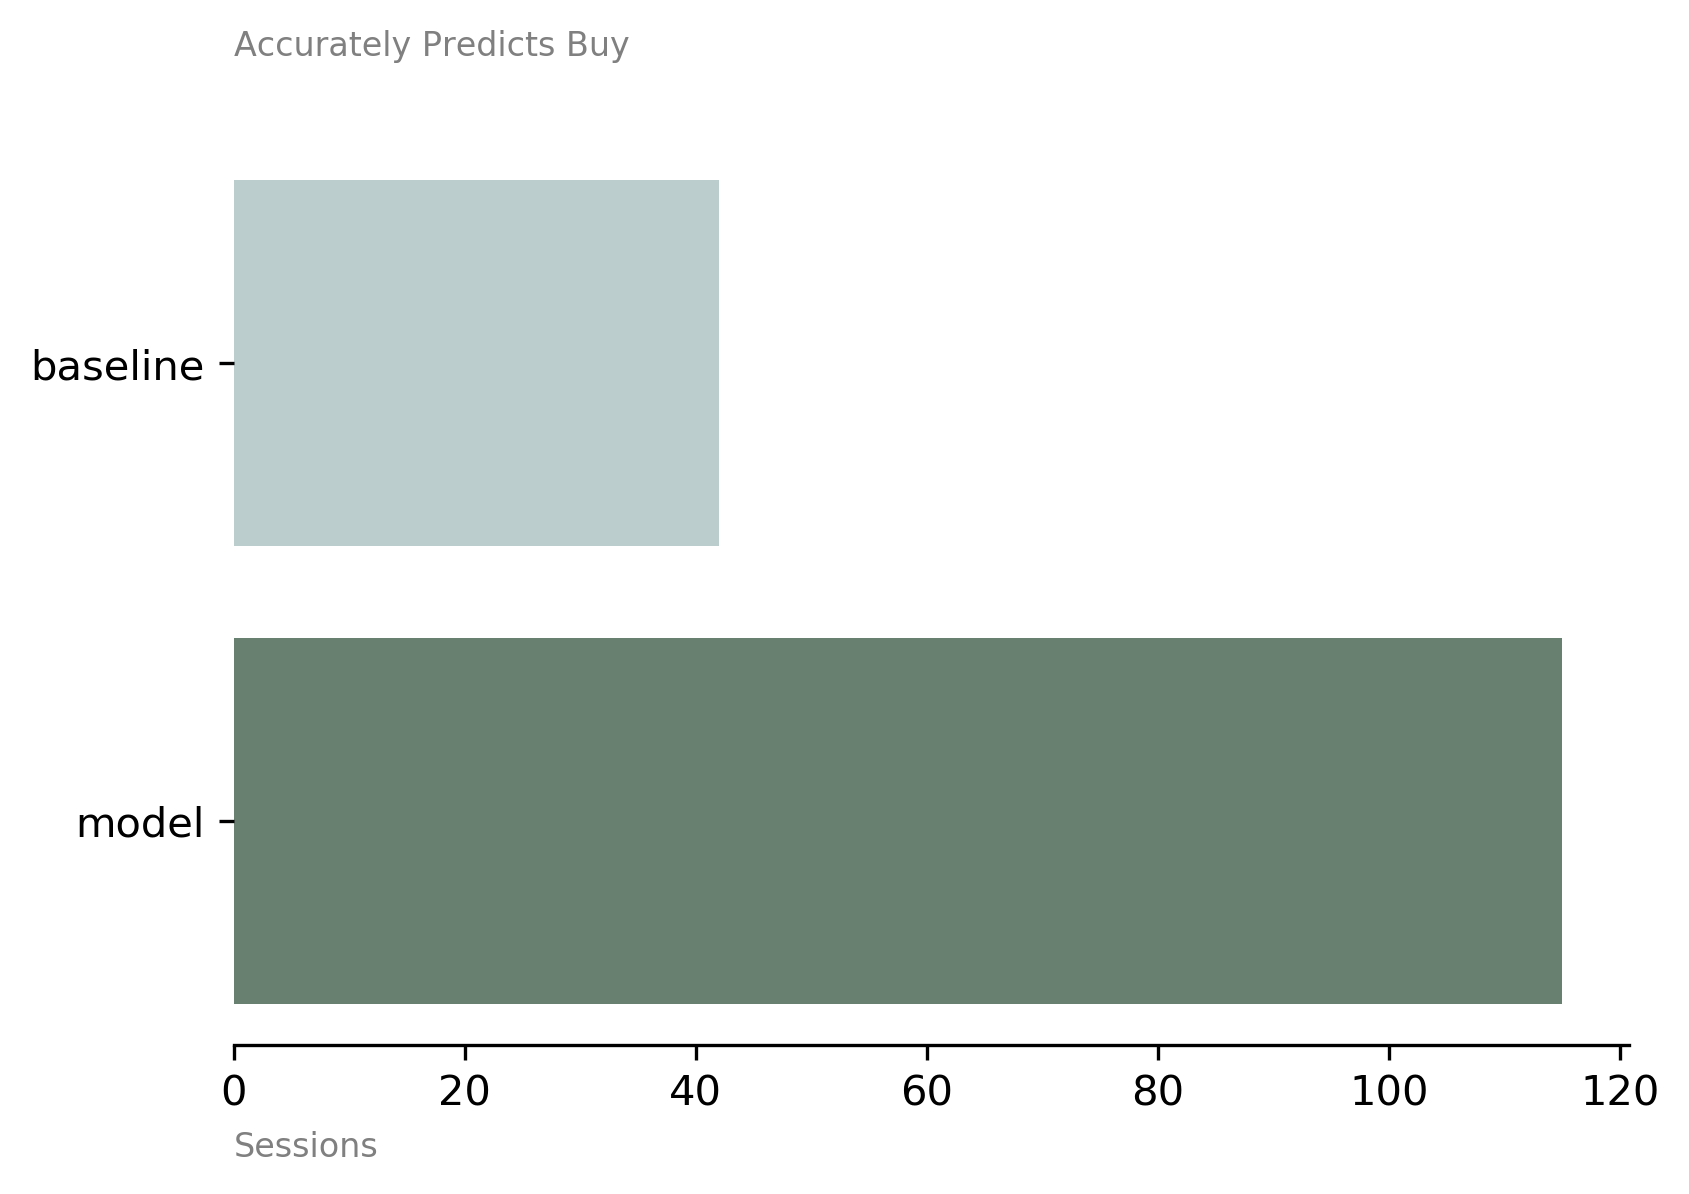

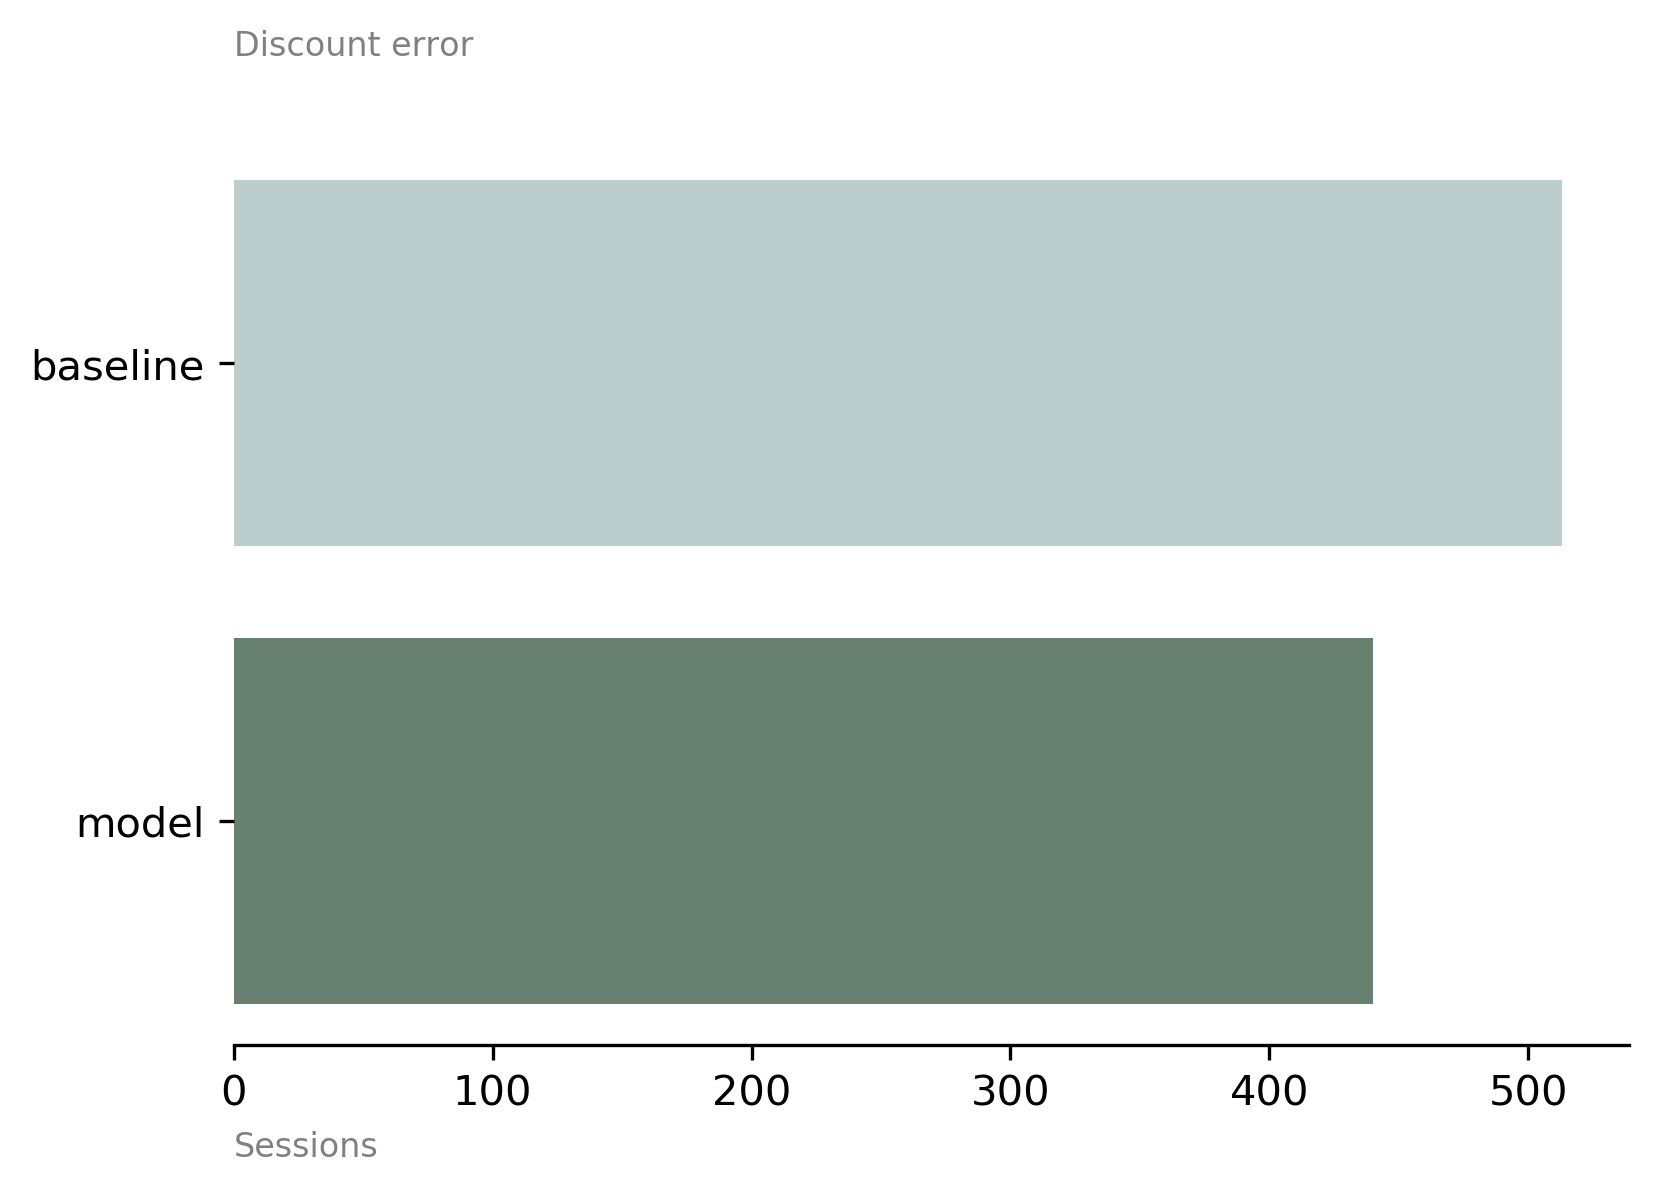

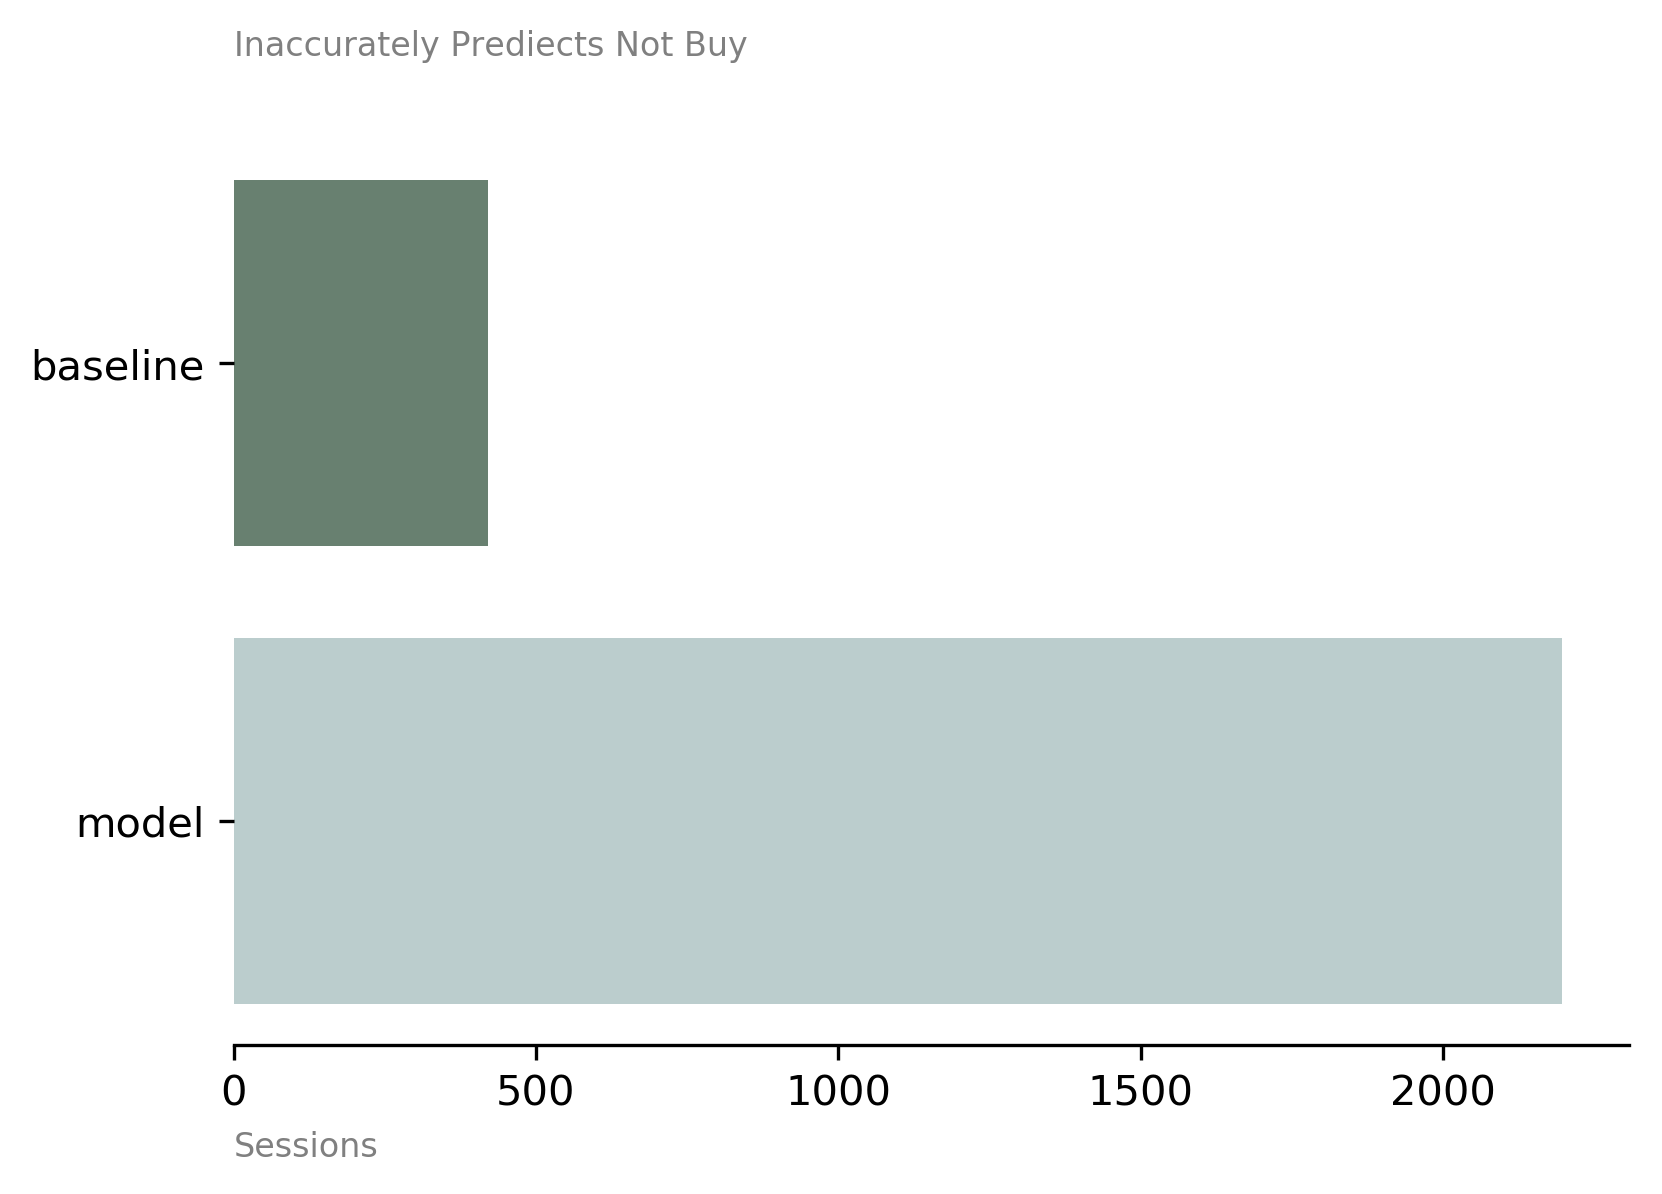

In [428]:
model_confusion = confusion_matrix(y_test, y_pred_test)
baseline_confusion = confusion_matrix(y_test, y_base_pred_test)
color = ('#688070','#bbcdcd')
# accurately predict buy
plots = {
    'model': model_confusion[1,1],
    'baseline': baseline_confusion[1,1]
}
plot_errors(plots, 'Accurately Predicts Buy', 'acc_buy', color)

# false neg
plots = {
    'model': model_confusion[1,0],
    'baseline': baseline_confusion[1,0]
}
plot_errors(plots, 'Discount error', 'disc_err', color)

color = ('#bbcdcd','#688070')

# false pos
plots = {
    'model': model_confusion[0,1],
    'baseline': baseline_confusion[0,1]
}
plot_errors(plots, 'Inaccurately Prediects Not Buy', 'lost_sale', color)

In [397]:
plots.values()

dict_values([115, 42])